# Quick SAMPIC Waveform Viewer

Simple notebook for quick waveform visualization using PyROOT.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (14, 6)

# Paths
DATA_FILE = "../../output.root"
BUILD_LIB_PATH = "../../build/lib"

In [2]:
# Load SAMPIC data product libraries
libs_to_load = [
    "libanalysis_pipeline_core.so",
    "libunpacker_data_products_core.so",
    "libunpacker_data_products_sampic.so",
]

for lib in libs_to_load:
    path = os.path.join(BUILD_LIB_PATH, lib)
    if os.path.exists(path):
        print(f"Loading {lib}...")
        ROOT.gSystem.Load(path)
    else:
        print(f"Warning: {lib} not found")

Loading libanalysis_pipeline_core.so...
Loading libunpacker_data_products_core.so...
Loading libunpacker_data_products_sampic.so...


In [3]:
# Open file and get tree
f = ROOT.TFile.Open(DATA_FILE)
if not f or f.IsZombie():
    print(f"Error: Could not open file {DATA_FILE}")
else:
    tree = f.Get("events")
    print(f"Loaded tree with {tree.GetEntries()} entries")
    print()  # Blank line before listing branches
    print("Available branches:")
    for branch in tree.GetListOfBranches():
        print(f"  - {branch.GetName()}")
    if tree.GetBranch("has_sampic_collector_timing"):
        print()  # Separate explanatory note
        print("Branch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.")


Loaded tree with 85135 entries

Available branches:
  - sampic_event
  - sampic_event_timing
  - sampic_collector_timing
  - has_sampic_collector_timing

Branch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.


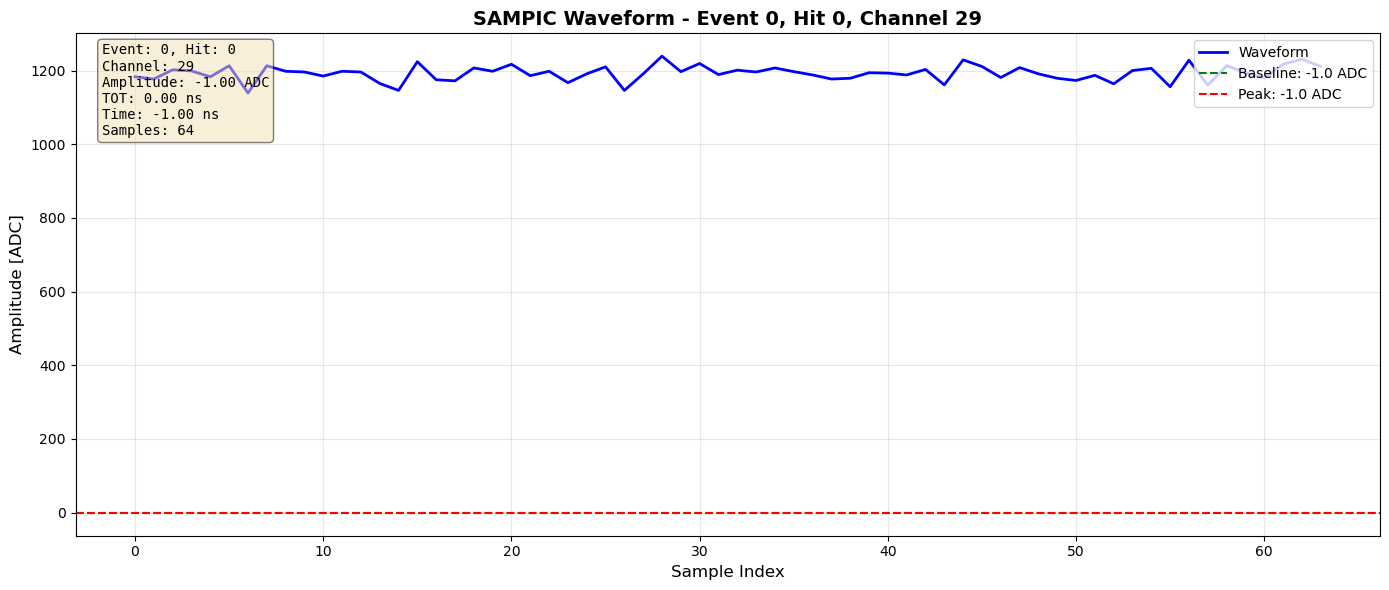

In [4]:
# Interactive waveform plotter
def plot_hit(event_num=0, hit_num=0):
    """Plot a single hit waveform."""
    if event_num >= tree.GetEntries():
        print(f"Event {event_num} out of range (max: {tree.GetEntries()-1})")
        return
    
    tree.GetEntry(event_num)
    event = tree.sampic_event
    
    if hit_num >= len(event.hits):
        print(f"Hit {hit_num} out of range (event {event_num} has {len(event.hits)} hits)")
        return
    
    hit = event.hits[hit_num]
    waveform = hit.corrected_waveform
    
    if len(waveform) == 0:
        print(f"Hit {hit_num} in event {event_num} has no waveform data")
        return
    
    # Convert ROOT vector to numpy array
    wf_array = np.array([waveform[i] for i in range(len(waveform))], dtype=np.float32)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    samples = np.arange(len(wf_array))
    ax.plot(samples, wf_array, 'b-', linewidth=2, label='Waveform')
    ax.axhline(y=hit.baseline, color='green', linestyle='--', linewidth=1.5, 
               label=f'Baseline: {hit.baseline:.1f} ADC')
    ax.axhline(y=hit.peak, color='red', linestyle='--', linewidth=1.5,
               label=f'Peak: {hit.peak:.1f} ADC')
    
    # Add text box with hit info
    info_text = f"""Event: {event_num}, Hit: {hit_num}
Channel: {hit.channel}
Amplitude: {hit.amplitude:.2f} ADC
TOT: {hit.tot_value:.2f} ns
Time: {hit.time_instant:.2f} ns
Samples: {len(wf_array)}"""
    
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontfamily='monospace', fontsize=10)
    
    ax.set_xlabel('Sample Index', fontsize=12)
    ax.set_ylabel('Amplitude [ADC]', fontsize=12)
    ax.set_title(f'SAMPIC Waveform - Event {event_num}, Hit {hit_num}, Channel {hit.channel}', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example: plot first hit from first event
plot_hit(0, 0)

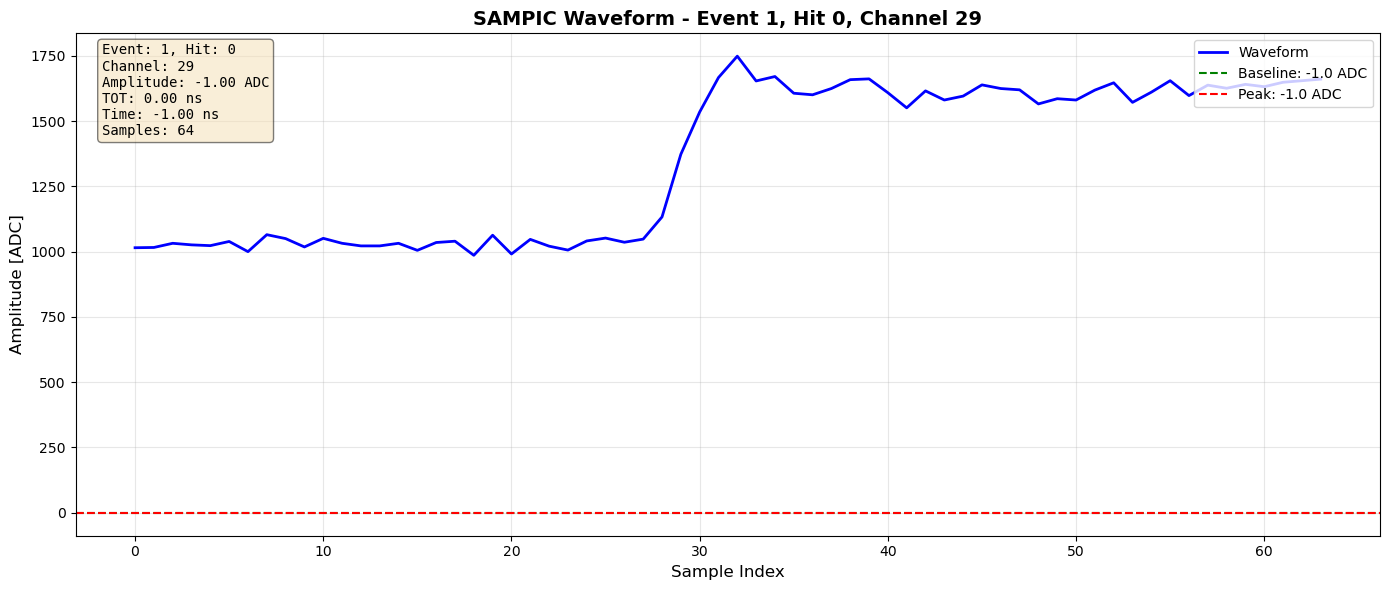

In [5]:
# Plot different hits - change these numbers!
plot_hit(event_num=1, hit_num=0)

In [6]:
# Explore: find events with large amplitudes
for i in range(min(20, tree.GetEntries())):
    tree.GetEntry(i)
    event = tree.sampic_event
    for j, hit in enumerate(event.hits):
        if hit.amplitude > 100:  # Adjust threshold as needed
            print(f"Event {i}, Hit {j}: Ch {hit.channel}, Amp {hit.amplitude:.1f}, "
                  f"Samples {len(hit.corrected_waveform)}")

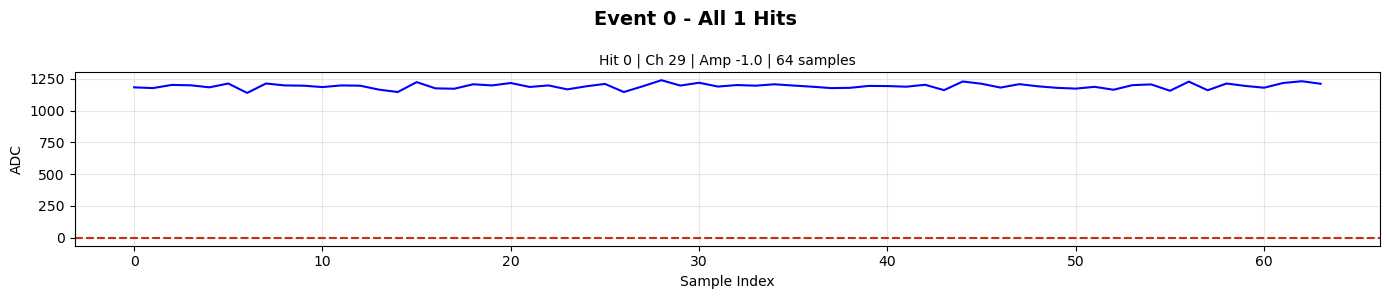

In [7]:
# Plot all hits from one event
def plot_event(event_num=0):
    """Plot all hits from a single event."""
    if event_num >= tree.GetEntries():
        print(f"Event {event_num} out of range")
        return
    
    tree.GetEntry(event_num)
    event = tree.sampic_event
    num_hits = len(event.hits)
    
    if num_hits == 0:
        print(f"Event {event_num} has no hits")
        return
    
    fig, axes = plt.subplots(num_hits, 1, figsize=(14, 3*num_hits), squeeze=False)
    axes = axes.flatten()
    
    for i, hit in enumerate(event.hits):
        wf = hit.corrected_waveform
        if len(wf) > 0:
            wf_array = np.array([wf[k] for k in range(len(wf))], dtype=np.float32)
            axes[i].plot(wf_array, 'b-', linewidth=1.5)
            axes[i].axhline(y=hit.baseline, color='g', linestyle='--', alpha=0.7)
            axes[i].axhline(y=hit.peak, color='r', linestyle='--', alpha=0.7)
            axes[i].set_ylabel('ADC')
            axes[i].set_title(f'Hit {i} | Ch {hit.channel} | Amp {hit.amplitude:.1f} | '
                             f'{len(wf)} samples', fontsize=10)
            axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Sample Index')
    fig.suptitle(f'Event {event_num} - All {num_hits} Hits', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot first event
plot_event(0)

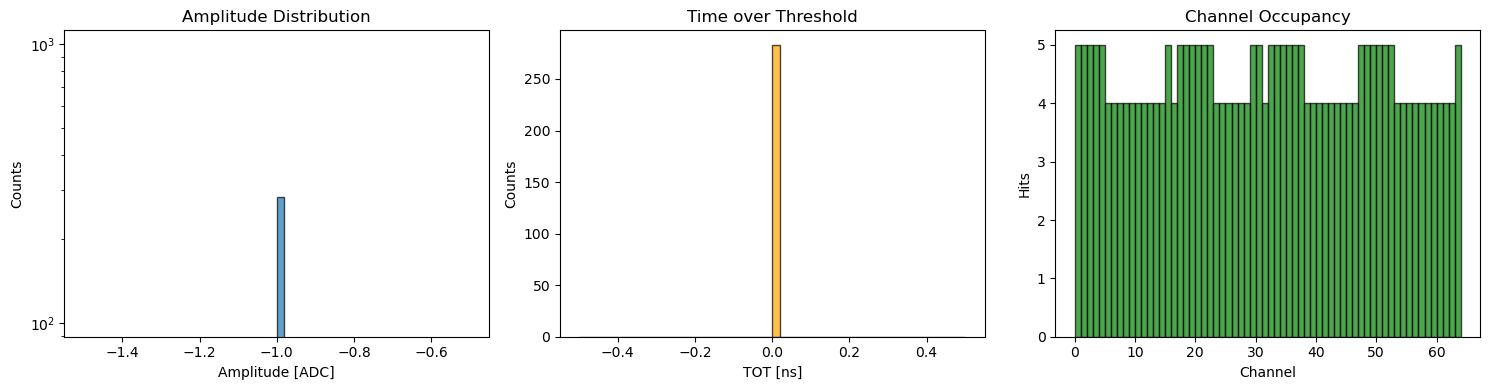


Total hits (from 50 events): 283
Amplitude range: [-1.0, -1.0] ADC
Mean amplitude: -1.0 ± 0.0 ADC
Active channels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [8]:
# Quick statistics - collect data from first N events
n_events = min(50, tree.GetEntries())

all_amps = []
all_tots = []
all_channels = []

for i in range(n_events):
    tree.GetEntry(i)
    event = tree.sampic_event
    for hit in event.hits:
        all_amps.append(hit.amplitude)
        all_tots.append(hit.tot_value)
        all_channels.append(hit.channel)

all_amps = np.array(all_amps)
all_tots = np.array(all_tots)
all_channels = np.array(all_channels)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(all_amps, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Amplitude [ADC]')
axes[0].set_ylabel('Counts')
axes[0].set_title('Amplitude Distribution')
axes[0].set_yscale('log')

axes[1].hist(all_tots, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('TOT [ns]')
axes[1].set_ylabel('Counts')
axes[1].set_title('Time over Threshold')

axes[2].hist(all_channels, bins=64, range=(0, 64), alpha=0.7, edgecolor='black', color='green')
axes[2].set_xlabel('Channel')
axes[2].set_ylabel('Hits')
axes[2].set_title('Channel Occupancy')

plt.tight_layout()
plt.show()

print(f"\nTotal hits (from {n_events} events): {len(all_amps)}")
print(f"Amplitude range: [{all_amps.min():.1f}, {all_amps.max():.1f}] ADC")
print(f"Mean amplitude: {all_amps.mean():.1f} ± {all_amps.std():.1f} ADC")
print(f"Active channels: {np.unique(all_channels)}")